# LAB 6: Machine Translation. Italian to English with Seq2Seq RNNs with attention mechanism.

### Objectives:
1. Understand the seq2seq model architecture.
2. Understand the attention mechanism.
3. Implement a seq2seq model with attention mechanism for machine translation.
4. Train the model on a Italian to English translation dataset.
5. Translate Italian sentences to English.
6. Evaluate the model using quantitative and qualitative evaluation methods.

#### Importing Required Libraries


In [2]:
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import torch.optim as optim
from tqdm import tqdm


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data and SetUp

#### Set Up Wandb for Experiment Tracking

In [3]:
import wandb
wandb.init(project="Machine_Translation", entity="nlp_2024", name="trial_2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neildlf (nlp_2024). Use `wandb login --relogin` to force relogin


#### Data

Data can be found in our [github](https://github.com/Neilus03/NLP-2024/blob/main/data/eng-ita.txt).

The dataset is a txt file that looks like this:

```
I haven't eaten pizza recently. Io non ho mangiato della pizza di recente.
I haven't figured that out yet.	Non l'ho ancora capito.
Hello! Ciao!
I saw you in the park with Tom.	L'ho vista al parco con Tom.
```



#### Creating the Lang Class

In [4]:


# Define the start-of-sequence (SOS) and end-of-sequence (EOS) tokens
SOS_token = 0
EOS_token = 1

# Define the language class
class Lang:
    '''
    Lang class to store the language vocabulary and word-to-index & index-to-word mappings.
    It also stores the count of each word in the vocabulary
    '''
    def __init__(self, language):
        self.language = language
        self.word2index = {}  # dictionary to map words to indices
        self.word2count = {}  # dictionary to count the occurrences of each word
        self.index2word = {0: "SOS", 1: "EOS"}  # dictionary to map indices to words
        self.n_words = 2  # Count SOS and EOS tokens (initially 2)

    def addSentence(self, sentence):
        # Add each word in the sentence to the language
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Add a word to the language
        if word not in self.word2index:
            # If the word is not already in the dictionary, add it
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            # If the word is already in the dictionary, increment its count
            self.word2count[word] += 1

#### Preprocessing the Data a little bit

In [5]:
def unicodeToAscii(unicode_string):
    # Convert unicode characters to ASCII
    ascii_string = ''
    for c in unicodedata.normalize('NFD', unicode_string): # NFD = Normalization Form Canonical Decomposition
        if unicodedata.category(c) != 'Mn': # Mn = Nonspacing_Mark
            ascii_string += c
    return ascii_string


def normalizeString(s):
    # Normalize the string by:
    
    # converting to lowercase,
    s = unicodeToAscii(s.lower().strip())
    #removing accents 
    s = re.sub(r"([.!?])", r" \1", s)
    #replacing non-alphabetic characters with spaces
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    #removing extra spaces
    return s.strip()


#### Create read_data function, which reads the data from the file and returns the input and target language pairs.

In [6]:
def read_data(lang1, lang2, reverse=True, verbose=False):
    '''
    Read the data file, split the file into lines and split
    lines into pairs. the `reverse` flag is used to translate from italian
    to english instaed of the default english to italian
    '''
    if verbose:
        print("Opening Data")
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Create Lang instances
    input_lang = Lang(lang1) if not reverse else Lang(lang2)
    output_lang = Lang(lang2) if not reverse else Lang(lang1)
    
    # Leave pairs as they are if not reverse, otherwise reverse the pairs
    pairs = [list(reversed(p)) for p in pairs] if reverse else pairs

    # Return the language vocabulary and the pairs
    return input_lang, output_lang, pairs

#### Example usage of the read_data function, and how the data looks like.

In [7]:
#Example usage of the read_data 
input_lang, output_lang, pairs = read_data('eng', 'ita', reverse=True, verbose=False)
print(random.choice(pairs), input_lang.language, output_lang.language)
input_lang, output_lang, pairs = read_data('eng', 'ita', False, verbose=False)
print(random.choice(pairs), input_lang.language, output_lang.language)

['io ho solamente un giardino piccolo', 'i only have a small garden'] ita eng
['tom didn t feel tired', 'tom non si sentiva stanco'] eng ita


#### Trim the dataset to contain only 10000 examples and only phrases with less than 10 words.
This is done to reduce the training time and to make the model learn faster.
If you have a better GPU, you can increase the number of examples and the length of the phrases,
sadly we are GPU-Poor hahaha, maybe Dani and Joan can grab some from the CVC.

In [8]:
MAX_LENGTH = 10
MAX_PAIRS = 100000

def filterPair(p):
    return (len(p[0].split(' ')) and len(p[1].split(' '))) < MAX_LENGTH


def trim_dataset(pairs):
    # Filter pairs using the filterPair condition and choosing 100000 random pairs
    pairs = [pair for pair in pairs if filterPair(pair)]
    return random.sample(pairs, MAX_PAIRS)


The full process for preparing the data is:

-   Read text file and split into lines, split lines into pairs
-   Normalize text, filter by length and content
-   Make word lists from sentences in pairs


In [9]:
def prepare_data(lang1, lang2, reverse=False):
    ''''
    Prepare the data for training by reading the data, filtering the pairs and counting the words
    Returns the input and output language instances and the processed pairs
    '''
    # Read the data
    input_lang, output_lang, pairs = read_data(lang1, lang2, reverse, verbose=True)
    print("Read all the %s sentence pairs in the dataset" % len(pairs))
    # Filter the pairs
    pairs = trim_dataset(pairs)
    print("Trimmed to %s sentence pairs using the trim_dataset function" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(f"There are {input_lang.n_words} words in {input_lang.language} and {output_lang.n_words} words in {output_lang.language}")

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'ita')
print(random.choice(pairs))

Opening Data
Read all the 345244 sentence pairs in the dataset
Trimmed to 100000 sentence pairs using the trim_dataset function
There are 9203 words in eng and 17191 words in ita
['tom will eventually get tired', 'tom finira per stancarsi']


## The Seq2Seq Model

The model is composed of an encoder and a decoder. The encoder reads the input sequence and outputs a context vector for each word in the input sequence. The decoder reads the context vector and generates the output sequence, hopefully translating the input sequence to the output sequence.

![](https://www.guru99.com/images/1/111318_0848_seq2seqSequ1.png)

### Encoder
The encoder of a seq2seq network is a RNN, in our case we'll use a GRU for the sake of simplicity.
This GRU encoder outputs a vector and a hidden state, and uses the hidden state for the
next input word.


In [10]:
class EncoderRNN(nn.Module):
    '''
    EncoderRNN class to encode the input language, it uses an embedding layer and a GRU layer
    basically it encodes the input language into a hidden state.
    '''
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #Embedding layer to convert words to vectors of fixed size
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        #GRU layer to encode the input language
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
        
        #Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        '''Forward pass of the encoder'''
        #Convert the input to embeddings and apply dropout
        embedded = self.dropout(self.embedding(input))
        #Pass the embeddings through the GRU layer and get the output and hidden state
        output, hidden = self.gru(embedded)
        return output, hidden

#### Example usage of the EncoderRNN

In [11]:
#Hidden size
hidden_size = 256

#Create an instance of the EncoderRNN 
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

#input tensor, it has a batch size of 1 and a sequence length of 10
input_tensor = torch.randint(0, input_lang.n_words, (1, 10)).to(device) #random input tensor [1, 10] with values between 0 and input_lang.n_words

#output and hidden state of the encoder after passing the input tensor
output, hidden = encoder(input_tensor)

#Print interesting information
print(f"Input Tensor Shape: {input_tensor.shape}")
print("-"*100)
print(f"Output Shape: {output.shape}")
print(f"Encoder Output: {output}")
print("-"*100)
print(f"Hidden Shape: {hidden.shape}")
print(f"Encoder Hidden: {hidden}")

Input Tensor Shape: torch.Size([1, 10])
----------------------------------------------------------------------------------------------------
Output Shape: torch.Size([1, 10, 256])
Encoder Output: tensor([[[ 0.1132, -0.0479,  0.1253,  ..., -0.2542,  0.0698,  0.0835],
         [-0.4362, -0.2714,  0.3046,  ..., -0.5266,  0.1589, -0.5989],
         [ 0.0615,  0.3444,  0.4119,  ...,  0.1102,  0.2678, -0.4496],
         ...,
         [ 0.1466,  0.3474, -0.2855,  ..., -0.4451,  0.3108, -0.1636],
         [-0.1411, -0.1958, -0.4471,  ..., -0.5044,  0.0133, -0.2336],
         [-0.1002, -0.3398, -0.0719,  ..., -0.2869,  0.2598,  0.6053]]],
       grad_fn=<TransposeBackward1>)
----------------------------------------------------------------------------------------------------
Hidden Shape: torch.Size([1, 1, 256])
Encoder Hidden: tensor([[[-0.1002, -0.3398, -0.0719,  0.3451, -0.0128,  0.3821,  0.3283,
          -0.3865, -0.6305, -0.3688, -0.2543, -0.0007, -0.4896, -0.0577,
          -0.0288,  0.03

### Attention Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation, in this case we will use an Attention Decoder. In sequence-to-sequence models, an attention decoder lets the decoder focus on different parts of the encoder's output using a calculated set of "attention weights". These weights help create a weighted combination of encoder outputs (attn_applied), enhancing the decoder's ability to select accurate output words based on the input sequence's relevant parts. Here we use Bahdanau attention mechanism. The process involves training a feed-forward layer to calculate these weights, adjusted for varying sentence lengths.

In [12]:
class BahdanauAttention(nn.Module):
    '''
    The typical Badhanau Attention mechanism.
        1. Calculate the attention scores by applying a linear layer to the encoder outputs and decoder hidden state
        2. Apply a softmax to the scores to get the attention weights
        3. Multiply the attention weights by the encoder outputs to get the context vector
        4. Return the context vector and the attention weights
    '''
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        #Linear layers to calculate the attention scores
        self.Wa = nn.Linear(hidden_size, hidden_size) #W matrix [hidden_size x hidden_size]
        self.Ua = nn.Linear(hidden_size, hidden_size) #U matrix [hidden_size x hidden_size]
        self.Va = nn.Linear(hidden_size, 1) #V vector [hidden_size x 1]

    def forward(self, query, keys):
        #Get the sum of the projection of the query and keys
        addition = self.Wa(query) + self.Ua(keys) #Addition shape is [batch_size x seq_len x hidden_size]
        
        #Apply a non-linearity to the sum (tanh in this case because we want to keep the values between -1 and 1)
        activated_addition = torch.tanh(addition)#Activated addition shape is [batch_size x seq_len x hidden_size]
        
        #Get the attention scores by applying the V matrix to the activated addition
        scores = self.Va(activated_addition) #Scores shape right now is [batch_size x seq_len x 1]
        
        #Squeeze the scores to remove the last dimension and unsqueeze the scores to add a dimension at index 1
        scores = scores.squeeze(2).unsqueeze(1) #Scores shape is now [batch_size x 1 x seq_len]

        #Apply a softmax to the scores to get the attention weights adding up to 1
        weights = F.softmax(scores, dim=-1) #Weights shape is [batch_size x 1 x seq_len]
        
        #Multiply the weights by the keys to get the context vector (bmm stands for batch matrix multiplication)
        context = torch.bmm(weights, keys) #Context shape is [batch_size x 1 x hidden_size]

        #Return the context vector and the attention weights.
        return context, weights

class AttnDecoderRNN(nn.Module):
    '''
    Attention Decoder class to decode the encoder outputs and the hidden 
    state into the target language, hopefully making a good translation.
    It uses an embedding layer, an attention layer and a GRU layer 
    (you could add more layers if you want to improve the model)
    '''
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True) #2 * hidden_size because we concatenate the embeddings and context vector
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None): #encoder outputs and encoder hidden are returned by the encoder
        '''
        Forward takes care of the forward pass of the decoder, it loops over the whole sequence length,
        translating one word at a time by using the step_forward function.
        '''
        #Get the batch size
        batch_size = encoder_outputs.size(0) 
        
        #Initialize the decoder input with the SOS token for each sentence in the batch
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        
        #Initialize the decoder hidden state with the encoder hidden state 
        decoder_hidden = encoder_hidden
        
        #Initialize the decoder outputs and attention maps as empty lists
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            #Make a forward step in the decoder, get the output, hidden state and attention weights for the decoder
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            
            #Append the decoder output and attention weights to their respective lists
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            #If there is a target tensor, use it as the next input, otherwise use the decoder output
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1) #Get the index of the maximum value
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input, gradient is not computed for the input.

        #Concatenate the decoder outputs and attention weights along the sequence length dimension
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1) #Apply a log softmax to the decoder outputs
        attentions = torch.cat(attentions, dim=1)

        #Return the decoder outputs and attention weights
        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        '''
        forward_step takes care of the forward pass of the decoder for a single time step (i.e. a single word)
        '''
        #Get the embeddings of the input with the applied dropout
        embedded =  self.dropout(self.embedding(input))

        #Permute the hidden state to have the batch size as the first dimension
        query = hidden.permute(1, 0, 2) #from [1, batch_size, hidden_size] to [batch_size, 1, hidden_size]
        
        #Get the context vector and attention weights by applying the attention mechanism (Bahdanau)
        context, attn_weights = self.attention(query, encoder_outputs)
        
        #Concatenate the embeddings and context vector along the hidden size dimension
        input_gru = torch.cat((embedded, context), dim=2) #Concatenation shape is [batch_size x 1 x 2 * hidden_size]
        
        #Pass the concatenated tensor through the GRU layer, get the output and hidden state
        output, hidden = self.gru(input_gru, hidden)
        
        #Pass the output through a linear layer to get the decoder output
        output = self.out(output) #Now shape is [batch_size x 1 x output_size] 
                                  #where output_size is the number of words in the output language (i.e. Vocabulary size)

        #Return the decoder output, hidden state and attention weights
        return output, hidden, attn_weights

#### Example usage of the AttnDecoderRNN

In [13]:
#Example usage of the AttnDecoderRNN

#Create an instance of the AttnDecoderRNN
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

#Pass the encoder
decoder_outputs, decoder_hidden, attentions = decoder(output, hidden)

#Print interesting information
print(f"Decoder Outputs Shape: {decoder_outputs.shape}")
print(f"Decoder Hidden Shape: {decoder_hidden.shape}")
print(f"Attentions Shape: {attentions.shape}")

Decoder Outputs Shape: torch.Size([1, 10, 17191])
Decoder Hidden Shape: torch.Size([1, 1, 256])
Attentions Shape: torch.Size([1, 10, 10])



## Training



### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.

In [21]:
def sentence_to_indexes(lang, sentence):
    '''Get the indexes of the words in the sentence using the language vocabulary'''
    return [lang.word2index[word] for word in sentence.split(' ')]

def sentence_to_tensor(lang, sentence):
    ''' Turn sentence into tensor of word indices and add EOS token'''
    indexes = sentence_to_indexes(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def pair_to_tensor(pair):
    ''' Get the input and target tensors from the pair of sentences'''
    input_tensor = sentence_to_tensor(input_lang, pair[0])
    target_tensor = sentence_to_tensor(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloaders(batch_size):
    ''' Get the dataloaders for the training, validation and test sets'''
    #Get the input and output languages and the pairs from the data
    input_lang, output_lang, pairs = prepare_data('eng', 'ita', True) 

    # Splitting the data into train, validation, and test sets
    train_pairs, test_val_pairs = train_test_split(pairs, test_size=0.3, random_state=42)
    test_pairs, val_pairs = train_test_split(test_val_pairs, test_size=0.5, random_state=42)

    def create_dataloader(pairs):
        '''
        Create a dataloader from the pairs by converting the sentences to tensors
        and truncating the tensors to the maximum length if necessary
        '''
        #Get the amount of pairs
        n = len(pairs) 
        
        #Initialize the input and target tensors to zeros
        input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)  # MAX_LENGTH = 10 for now (defined at the beginning of the notebook)
        target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

        #Iterate over the pairs and convert the sentences to tensors
        for idx, (inp, tgt) in enumerate(pairs):
            #Get the indexes of the words in the sentences using the language vocabulary
            inp_ids = sentence_to_indexes(input_lang, inp) 
            tgt_ids = sentence_to_indexes(output_lang, tgt)
            
            #Truncate to MAX_LENGTH-1 if necessary, which shouldn't be the case because all the filtered data is already less or equal than MAX_LENGTH
            
            if len(inp_ids) >= MAX_LENGTH: 
                inp_ids = inp_ids[:MAX_LENGTH-1]  # Truncate to MAX_LENGTH-1 if necessary
                tgt_ids = tgt_ids[:MAX_LENGTH-1]  # Truncate to MAX_LENGTH-1 if necessary
            inp_ids.append(EOS_token)
            tgt_ids.append(EOS_token)
            
            #Add the tensors to the input and target tensors
            input_ids[idx, :len(inp_ids)] = inp_ids 
            target_ids[idx, :len(tgt_ids)] = tgt_ids

        #Create a TensorDataset from the input and target tensors, TensorDataset is a PyTorch class to create datasets from tensors
        dataset = TensorDataset(torch.LongTensor(input_ids).to(device),
                                torch.LongTensor(target_ids).to(device))
        
        #Create a RandomSampler to sample the data randomly
        sampler = RandomSampler(dataset)
        
        #Create a DataLoader from the dataset and the sampler
        dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
        return dataloader

    # Creating separate dataloaders for the training, testing, and validation sets, how do we ensure they are differen
    train_dataloader = create_dataloader(train_pairs)
    test_dataloader = create_dataloader(test_pairs)
    val_dataloader = create_dataloader(val_pairs)
    
    #Return the input and output languages and the dataloaders for training, testing, and validation
    return input_lang, output_lang, train_dataloader, test_dataloader, val_dataloader, test_pairs


#### Example usage of the dataloaders

In [22]:

# Example usage:
batch_size = 64
input_lang, output_lang, train_dataloader, test_dataloader, val_dataloader, test_pairs = get_dataloaders(batch_size)

print(f"Number of training batches: {len(train_dataloader)}")

#Sample a batch from the training dataloader
print(f"Sample Batch: { next(iter(train_dataloader))}")

Opening Data
Read all the 345244 sentence pairs in the dataset
Trimmed to 100000 sentence pairs using the trim_dataset function
There are 17156 words in ita and 9406 words in eng
Number of training batches: 1094
Sample Batch: [tensor([[   16,    41,  1811,     1,     0,     0,     0,     0,     0,     0],
        [   16,    61,  2341,    39,     1,     0,     0,     0,     0,     0],
        [   93,   893,   239,    96,    26,   740,   106,   230,  1480,     1],
        [   15,     8,    16,    85, 12170,     1,     0,     0,     0,     0],
        [    2,   397,   615,  4425,    37,  6331,     1,     0,     0,     0],
        [   43,  1221,   364,  1091,  7269, 12890, 12891,     1,     0,     0],
        [   16,   169,   317,   318,    18,   193,     1,     0,     0,     0],
        [    3,     6,   444,   212,     8,   312,     1,     0,     0,     0],
        [   43,    26,   150,   753,     6,  3294, 11315,    39,     1,     0],
        [  247,     3,  2596,  1799,     1,     0,   

### Training the model

To train the model, we start by passing the input sentence to the encoder, which saves all its outputs and the final hidden state. Then, the decoder starts with the <SOS> token as its initial input and uses the encoder’s last hidden state as its first hidden state.

We use Teacher forcing which is a technique where the true target outputs are used as each subsequent input to the decoder, rather than the decoder's own predictions. This method helps the model train faster but can lead to instability when the model is used in practice, as noted in research. This happens because the model might learn to form correct grammar and structure by following the lead given by the initial words, but it might not learn to generate the sentence independently from the input translation.

PyTorch's autograd system allows us to easily integrate teacher forcing randomly in training by using an if statement to decide when to apply it. We can then adjust the teacher_forcing_ratio to control how frequently teacher forcing is used.

In [23]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, train=True):
    '''
    train_epoch function to train the encoder and decoder for one epoch
    '''
    #First check if we are training or evaluating
    if train:
        #Set the encoder and decoder to training mode
        encoder.train()
        decoder.train()
    else:
        #Set the encoder and decoder to evaluation mode
        encoder.eval()
        decoder.eval()

    #initialize the total loss to 0
    total_loss = 0
    
    #iterate over the dataloader
    for data in dataloader:
        
        #Get the input and target tensors from the data
        input_tensor, target_tensor = data
        
        #Zero the gradients of the encoder and decoder for each batch
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        #Pass the input tensor through the encoder and get the outputs and hidden state
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        
        #Pass the outputs of the encoder through the decoder and get
        decoder_outputs, hidden, attn_weights = decoder(encoder_outputs, encoder_hidden, target_tensor)
        
        #Calculate the loss by comparing the decoder outputs and the target tensor
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        
        if train:
            #If training, backpropagate the loss and update the parameters, if evaluating, only accumulate the loss
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            
        #Update the total loss
        total_loss += loss.item()
        
    #Return the average loss for the epoch
    return total_loss / len(dataloader)


In [24]:

def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=1, log_wandb=True, save_models=True):
    
    #Initialize best_val_loss
    best_val_loss = 10000
    
    #Initiaalize max_patience
    max_patience = 5
    
    #Initialize the plot losses list
    plot_losses = []

    #Define the optimizer and the criterion
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    #Iterate over the epochs
    for epoch in tqdm(range(1, n_epochs + 1)):
        #Train the model for one epoch
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, train=True)
        
        #Evaluate the model for one epoch
        val_loss = train_epoch(val_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, train=False)
        
        #Plot the losses
        plot_losses.append((train_loss, val_loss))

        if log_wandb:
            #Log the losses to wandb
            wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

        if epoch % print_every == 0:
            #Print the losses and the time elapsed for every print_every epochs
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            max_patience = 5
            if save_models:
                #Save the encoder and decoder models if val loss improved
                torch.save(encoder.state_dict(), f"models/MT_encoder_epoch_{epoch}.pt")
                torch.save(decoder.state_dict(), f"models/MT_decoder_epoch_{epoch}.pt")
            best_val_loss = val_loss
        else:
            max_patience -= 1
            if max_patience == 0:
                print(f"Early stopping at epoch {epoch} due to non improvement in validation loss")
                break
            

    if log_wandb:
        wandb.finish()


#### Finally training

In [25]:
# Train the model

hidden_size = 128
batch_size = 64

input_lang, output_lang, train_dataloader, test_dataloader, val_dataloader, test_pairs = get_dataloaders(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, val_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001, log_wandb=True, save_models=True)


Opening Data
Read all the 345244 sentence pairs in the dataset
Trimmed to 100000 sentence pairs using the trim_dataset function
There are 17136 words in ita and 9434 words in eng


## Evaluation

#### Attention visualization

One nice thing about attention is that it is highly interpretable in its
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can look where the network is focused most
at each time step.

In [48]:

import matplotlib.pyplot as plt
from matplotlib import ticker



def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig(f'plots/attention_{input_sentence}.png')

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])




#### Qualitative Evaluation function 

In [49]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = sentence_to_tensor(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the test set and print out the
input, target, and output to make some subjective quality evaluations.


> la stanza era priva di mobilio
= the room was bare of furniture
input = la stanza era priva di mobilio
output = leaves kindness generosity invalid stings distracted thai missouri fisherman tempered
< leaves kindness generosity invalid stings distracted thai missouri fisherman tempered

> incontrai un amica di mary
= i met a friend of mary s
input = incontrai un amica di mary
output = third standing dissatisfied constructed socializing television flunk declutter nation sidewalk


/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


< third standing dissatisfied constructed socializing television flunk declutter nation sidewalk

> lui corse un grosso rischio
= he took a big risk
input = lui corse un grosso rischio
output = bonehead lake suits argue science slowly squirrel issued healing sucked
< bonehead lake suits argue science slowly squirrel issued healing sucked

> per piacere siate oneste con me
= please be honest with me
input = per piacere siate oneste con me
output = third carbon honk use roots oath tightly money altar channel


/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


< third carbon honk use roots oath tightly money altar channel

> nessuno l ha forzato ad aiutarmi
= nobody forced you to help me
input = nessuno l ha forzato ad aiutarmi
output = bonehead lake ocean peaches woebegone by pe appropriately swine pathetic
< bonehead lake ocean peaches woebegone by pe appropriately swine pathetic

> dobbiamo agire rapidamente
= we have to act quickly
input = dobbiamo agire rapidamente
output = bonehead lake manchester joining impress unwilling manchester joining dazed hiring


/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


< bonehead lake manchester joining impress unwilling manchester joining dazed hiring

> io sono una cittadina statunitense
= i m a us citizen
input = io sono una cittadina statunitense
output = bonehead lake manchester turns stressed sociable spring moored tuesday sunscreen
< bonehead lake manchester turns stressed sociable spring moored tuesday sunscreen

> lui e impegnato a fare qualcosa
= he is busy doing something
input = lui e impegnato a fare qualcosa
output = bonehead lake whispered doorbell raining competitors algorithm noguchi regards objective


/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


< bonehead lake whispered doorbell raining competitors algorithm noguchi regards objective

> che cosa vi fa pensare che funzionera ?
= what makes you think that ll work ?
input = che cosa vi fa pensare che funzionera ?
output = leaves transparent frank alexei seeds hemoglobin reliable children actress cigarettes
< leaves transparent frank alexei seeds hemoglobin reliable children actress cigarettes

> noi dovremmo lavorare piu velocemente
= we should work faster
input = noi dovremmo lavorare piu velocemente
output = bonehead lake yelled cobra funds funds improvement via hearing intrigued


/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/tmp/ipykernel_1021939/3766368508.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_1021939/3766368508.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


< bonehead lake yelled cobra funds funds improvement via hearing intrigued



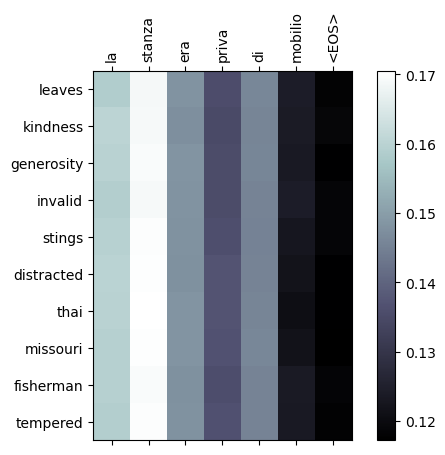

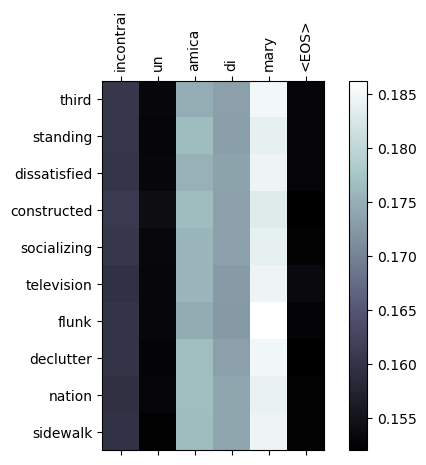

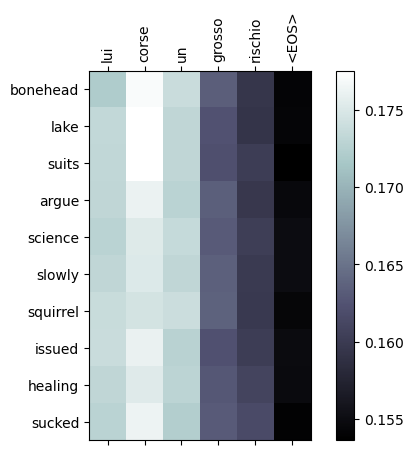

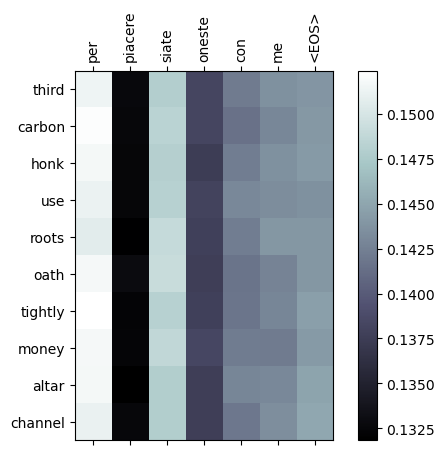

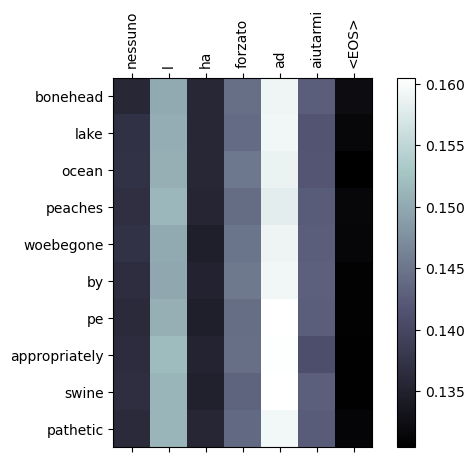

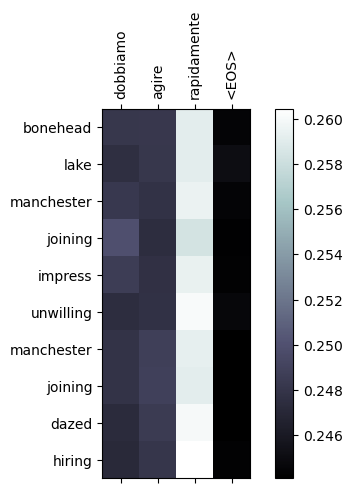

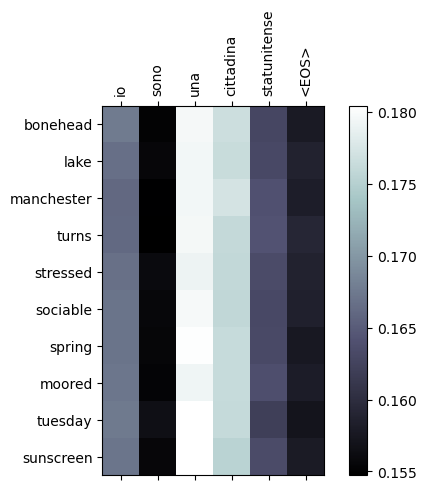

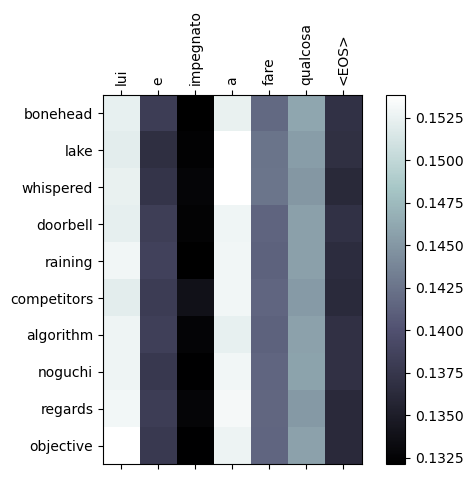

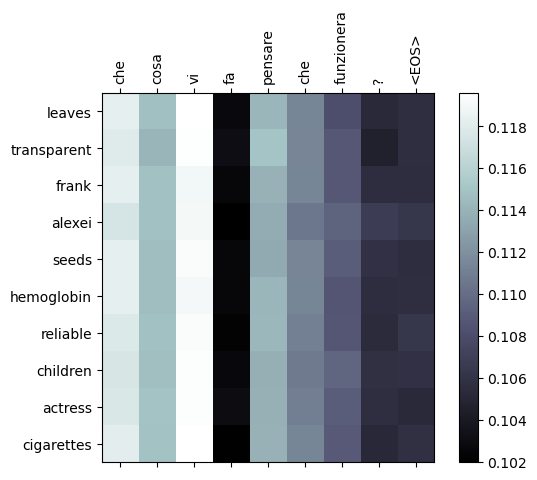

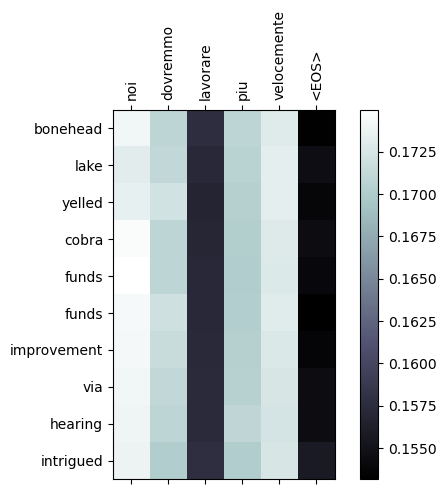

In [50]:
def evaluateRandomly(encoder, decoder, test_pairs, n=10):
    for i in range(n):
        pair = random.choice(test_pairs) #pair = [input_sentence, target_sentence]
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        evaluateAndShowAttention(pair[0])
        print('<', output_sentence)
        print('')
        

encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, test_pairs)

#### Quantitative Evluation

We will use BLEU

In [52]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = sentence_to_tensor(input_lang, sentence).to(device)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden  # Use the last hidden state from the encoder to start the decoder
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                encoder_outputs, decoder_hidden, decoder_input)
            decoder_attentions[di] = decoder_attention.data.squeeze(0)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluate_bleu(encoder, decoder, pairs, input_lang, output_lang, n=1000):
    references = []
    candidates = []
    for i in range(n):
        pair = random.choice(pairs)
        output_words, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        references.append([pair[1].split(' ')])  # the reference sentence
        candidates.append(output_words[:-1])  # the candidate sentence, exclude <EOS>

    # Calculate BLEU score
    bleu_score = corpus_bleu(references, candidates, smoothing_function=SmoothingFunction().method4)
    print(f'BLEU score on test dataset: {bleu_score:.4f}')

# Example usage
evaluate_bleu(encoder, decoder, test_pairs, input_lang, output_lang)


IndexError: index 1 is out of bounds for dimension 1 with size 1

Exercises
=========

-   Try with a different dataset
    -   Another language pair
    -   Human → Machine (e.g. IOT commands)
    -   Chat → Response
    -   Question → Answer
-   Replace the embeddings with pretrained word embeddings such as
    `word2vec` or `GloVe`
-   Try with more layers, more hidden units, and more sentences. Compare
    the training time and results.
-   If you use a translation file where pairs have two of the same
    phrase (`I am test \t I am test`), you can use this as an
    autoencoder. Try this:
    -   Train as an autoencoder
    -   Save only the Encoder network
    -   Train a new Decoder for translation from there
